Sara's found that some of Tully's clusters overlap in Y3.  Do we have any overlapping clusters in the Y1 sample?

In [1]:
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
import astropy.constants as const
import astropy.units as u

import numpy as np

from scipy.spatial.distance import cdist, euclidean

import ligo.skymap.plot

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
import matplotlib as mpl

# from matplotlib.projections import get_projection_names

# Custom functions / classes
import sys
sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
from z_CMB_convert import convert_z_frame

In [2]:
h = 1
H0 = 100*h*u.km/u.s/u.Mpc

# Access Y1 (Iron) cluster calibrators

This file is generated in `TF_Y1_cluster_calibration_AnthonyUpdates_weightsVmax-1_KAD.ipynb`.

In [3]:
caltab = Table.read('SGA-2020_iron_Vrot_cluster_calib_z0p1_Anthony.fits')

caltab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,MORPHTYPE_AI,JOHN_VI,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,CLUSTER_ID
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,,,,,,,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,bytes10,bytes6,float64,float64,float64,float64,float64,float64,int64
35725.0,SGA-2020 35725,PGC1224815,1224815,218.516655,2.3732835,S?,119.7,0.414954,0.31622776,0.028805595,24.58048,17.862,False,LEDA-20181114,9560,PGC1224815,1,True,218.516655,2.3732835,0.414954,2186p022,218.51673945189452,2.3732654125607757,0.7285664,SB26,119.49577,0.29847997,218.51645511612097,2.373413119352272,13.986177,8.9652,8.8493,8.537395,2.637311,5.3980026,7.7491693,10.108394,12.475642,14.781089,16.927706,19.368849,21.856993,20.057823,19.502214,19.152143,18.8512,18.349913,18.02569,18.36864,17.89226,17.569437,18.064114,17.604765,17.291239,17.866943,17.421322,17.12161,17.74925,17.301216,17.010185,17.675014,17.230236,16.939669,17.61827,17.176155,16.888216,17.581612,17.139238,16.852167,0.036243405,0.052957676,0.08686163,0.105829716,0.11953892,0.1407899,0.12557544,0.17631544,0.25353405,0.04001302,0.044960078,0.05253993,0.026287124,0.028849348,0.031466525,0.02200045,0.023913907,0.025489496,0.019614518,0.021171868,0.022508515,0.018323934,0.019594736,0.020753864,0.01745466,0.01849219

## Do we have any galaxies matched to multiple clusters?

In [4]:
unique, counts = np.unique(caltab['SGA_ID'], return_counts=True)

print(len(unique[counts > 1]), 'galaxies assigned to more than one cluster')

6 galaxies assigned to more than one cluster


In [5]:
duplicates = caltab[np.isin(caltab['SGA_ID'], unique[counts > 1])]

## How many galaxies in each cluster have been assigned to at least one other cluster?

In [6]:
unique, counts = np.unique(duplicates['CLUSTER_ID'], return_counts=True)

overlapping_clusters = unique[counts > 1]

for cluster, count in zip(overlapping_clusters, counts[counts > 1]):
    print(f'Cluster ID: {cluster}, Count: {count}')

Cluster ID: 100067, Count: 6
Cluster ID: 100094, Count: 6


## Make a list of which clusters overlap with another

Note that this is a menial task here, since we only have two clusters that have galaxies assigned to another cluster (so it's obvious that these two are our overlaps).  However, for completeness, I'm going to do this anyway, in case the sample changes.

In [7]:
cluster_overlap = {}
overlap_sets = set() # Store unique unordered pairs of overlapping clusters

for galaxy_id in np.unique(duplicates['SGA_ID']):

    galaxy_rows = duplicates[duplicates['SGA_ID'] == galaxy_id]

    # Get the list of clusters that this galaxy belongs to
    clusters = list(galaxy_rows['CLUSTER_ID'])

    # For each cluster, add the others this galaxy belongs to
    for cluster in clusters:
        
        if cluster not in cluster_overlap:
            cluster_overlap[cluster] = set()
            
        cluster_overlap[cluster].update([c for c in clusters if c != cluster])

    # Store the unique pair
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            pair = tuple(sorted((clusters[i], clusters[j])))
            overlap_sets.add(pair)


for cluster_id, overlaps in cluster_overlap.items():
    print(f'Cluster {cluster_id} overlaps with clusters {sorted(list(overlaps))}')

overlap_pairs = list(overlap_sets)

Cluster 100067 overlaps with clusters [100094]
Cluster 100094 overlaps with clusters [100067]


# Load cluster data

In [8]:
clusters_T = Table.read('../Tully15-Table3.fits')

# Convert Tully's central cluster velocities to heliocentric frame (to match the DESI redshift frame)
cls_coords = SkyCoord(clusters_T['SGLON'], clusters_T['SGLAT'], unit='deg', frame='supergalactic').icrs
z_hel = convert_z_frame(clusters_T['<Vcmba>']/const.c.to('km/s'), cls_coords.ra.deg, cls_coords.dec.deg, corrtype='-full')
clusters_T['HRV'] = z_hel*const.c.to('km/s')

In [9]:
clusters_K = Table.read('../Kourkchi17-Table2.fits.gz')

# Rename columns to match Tully's catalog
clusters_K['Nm'].name = 'Nmb'
clusters_K['sigmaL'].name = 'sigP'
clusters_K['sigmaV'].name = 'sigV'

# Convert from distance to distance modulus
clusters_K['DM'] = 5*np.log10(clusters_K['Dist'].value) + 25

# Define NestID
clusters_K['Nest'] = np.char.add('3', clusters_K['PGC1'].astype('str')).astype('int')

/tmp/ipykernel_2298274/3146560428.py:9: RuntimeWarning: divide by zero encountered in log10
  clusters_K['DM'] = 5*np.log10(clusters_K['Dist'].value) + 25


In [10]:
# Determine which clusters in Kourkchi's table are already in Tully's
K_keep = np.ones(len(clusters_T), dtype=bool)

for i in range(len(clusters_K)):
    K_keep = K_keep & (clusters_T['PGC1'] != clusters_K['PGC1'][i])

clusters_all = vstack([clusters_T[K_keep], clusters_K])

clusters = clusters_all['Nest', 'Nmb', 'PGC1', 'SGLON', 'SGLAT', 'DM', 'sigV', 'sigP', 'R2t', 'HRV'][clusters_all['Nmb'] >= 5]

# Plot the overlapping clusters

In [11]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def cluster_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a cluster.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the clusters coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [53]:
def plot_double_clusters(cluster_cat, cluster1, cluster2, galaxy_table, cluster_gals1, cluster_gals2):
    '''
    Plot the (ra, dec), (ra, z), and (dec, z) scatter plots of the two 
    overlapping clusters, along with the galaxies' distributions in ra, dec, and 
    z.


    PARAMETERS
    ==========

    cluster_cat : astropy table
        Table of cluster properties

    cluster1, cluster2 : integers
        Cluster IDs (Nest IDs) of each cluster.

    galaxy_table : astropy table
        Table of galaxy properties

    cluster_gals1, cluster_gals2 : lists
        List of SGA IDs for the galaxies assigned to each cluster.
    '''

    # Row for each cluster in the cluster table
    idx1 = cluster_cat['Nest'] == cluster1
    idx2 = cluster_cat['Nest'] == cluster2

    # Rows for galaxies in each cluster
    gal_idx1 = np.in1d(galaxy_table['SGA_ID'], cluster_gals1)
    gal_idx2 = np.in1d(galaxy_table['SGA_ID'], cluster_gals2)

    # Cluster 1's properties
    long_cluster1 = cluster_cat['SGLON'][idx1][0]
    lat_cluster1 = cluster_cat['SGLAT'][idx1][0]
    R2t_cluster1 = cluster_cat['R2t'][idx1][0]
    sigV_cluster1 = cluster_cat['sigV'][idx1][0]
    mu_cluster1 = cluster_cat['DM'][idx1][0]
    rv_helio_cluster1 = cluster_cat['HRV'][idx1][0]
    v_cluster1 = 100 * 10**(0.2*(mu_cluster1 - 25)) / (1 + rv_helio_cluster1/const.c.to_value('km/s'))

    # Cluster 2's properties
    long_cluster2 = cluster_cat['SGLON'][idx2][0]
    lat_cluster2 = cluster_cat['SGLAT'][idx2][0]
    R2t_cluster2 = cluster_cat['R2t'][idx2][0]
    sigV_cluster2 = cluster_cat['sigV'][idx2][0]
    mu_cluster2 = cluster_cat['DM'][idx2][0]
    rv_helio_cluster2 = cluster_cat['HRV'][idx2][0]
    v_cluster2 = 100 * 10**(0.2*(mu_cluster2 - 25)) / (1 + rv_helio_cluster2/const.c.to_value('km/s'))

    # Cluster sky coordinates
    cluster1_coord = SkyCoord(long_cluster1, lat_cluster1, unit='deg', frame='supergalactic').transform_to('icrs')
    cluster2_coord = SkyCoord(long_cluster2, lat_cluster2, unit='deg', frame='supergalactic').transform_to('icrs')

    #---------------------------------------------------------------------------
    # Cluster radius limits
    #---------------------------------------------------------------------------
    R2t_1p5_cluster1 = np.arctan(1.5*R2t_cluster1 / (v_cluster1/H0.value)) * u.radian
    R2t_3_cluster1 = np.arctan(3*R2t_cluster1 / (v_cluster1/H0.value)) * u.radian
    R2t_4_cluster1 = np.arctan(4*R2t_cluster1 / (v_cluster1/H0.value)) * u.radian
    
    R2t_1p5_cluster2 = np.arctan(1.5*R2t_cluster2 / (v_cluster2/H0.value)) * u.radian
    R2t_3_cluster2 = np.arctan(3*R2t_cluster2 / (v_cluster2/H0.value)) * u.radian
    R2t_4_cluster2 = np.arctan(4*R2t_cluster2 / (v_cluster2/H0.value)) * u.radian
    #---------------------------------------------------------------------------

    # Galaxy coordinates for cluster 1
    z_gals1 = galaxy_table['Z_DESI'][gal_idx1]
    ra_gals1 = galaxy_table['RA'][gal_idx1]
    dec_gals1 = galaxy_table['DEC'][gal_idx1]

    # Galaxy coordinates for cluster 2
    z_gals2 = galaxy_table['Z_DESI'][gal_idx2]
    ra_gals2 = galaxy_table['RA'][gal_idx2]
    dec_gals2 = galaxy_table['DEC'][gal_idx2]

    #---------------------------------------------------------------------------
    # Compute median redshift of galaxies
    #---------------------------------------------------------------------------
    z_gals1_sorted = np.sort(z_gals1)
    ngal1 = len(z_gals1_sorted)
    z_gals1_median = np.mean(z_gals1_sorted[ngal1//2:ngal1//2 + 2]) if (ngal1 % 2 == 0) else z_gals1_sorted[ngal1//2]

    z_gals2_sorted = np.sort(z_gals2)
    ngal2 = len(z_gals2_sorted)
    z_gals2_median = np.mean(z_gals2_sorted[ngal2//2:ngal2//2 + 2]) if (ngal2 % 2 == 0) else z_gals2_sorted[ngal2//2]
    #---------------------------------------------------------------------------

    # Galaxy sky coordinates
    gal1_coords = SkyCoord(ra=ra_gals1, dec=dec_gals1, unit='deg', frame='icrs')
    gal2_coords = SkyCoord(ra=ra_gals2, dec=dec_gals2, unit='deg', frame='icrs')

    # Median galaxy sky coordinates
    gal1_coords_median = cluster_median_coords(gal1_coords)
    gal2_coords_median = cluster_median_coords(gal2_coords)

    # Initialize figure
    fig = plt.figure(figsize=(12,8), tight_layout=True)

    #---------------------------------------------------------------------------
    # Plot the angular coordinates
    #---------------------------------------------------------------------------
    ax = plt.subplot(231, projection='astro degrees zoom', center=cluster1_coord, radius=R2t_4_cluster1+R2t_4_cluster2)
    ax.grid()

    # cluster 1
    ax.plot(gal1_coords.ra.deg, gal1_coords.dec.deg, 'o', c='tab:blue', transform=ax.get_transform('world'), alpha=0.5, label=f'{cluster1}')
    # ax.plot(gal1_coords_median.ra.deg, gal1_coords_median.dec.deg, 'D', c='tab:blue', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster1_coord.ra.deg, cluster1_coord.dec.deg, 'x', c='darkblue', transform=ax.get_transform('world'), ms=10, mew=5)

    # cluster 2
    ax.plot(gal2_coords.ra.deg, gal2_coords.dec.deg, 'o', c='tab:red', transform=ax.get_transform('world'), alpha=0.5, label=f'{cluster2}')
    # ax.plot(gal2_coords_median.ra.deg, gal2_coords_median.dec.deg, 'D', c='tab:red', transform=ax.get_transform('world'), ms=5, mew=5)
    ax.plot(cluster2_coord.ra.deg, cluster2_coord.dec.deg, 'x', c='darkred', transform=ax.get_transform('world'), ms=10, mew=5)

    inner1 = SphericalCircle(cluster1_coord, R2t_1p5_cluster1, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
    ax.add_patch(inner1)

    outer1 = SphericalCircle(cluster1_coord, R2t_3_cluster1, transform=ax.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
    ax.add_patch(outer1)

    inner2 = SphericalCircle(cluster2_coord, R2t_1p5_cluster2, transform=ax.get_transform('world'), edgecolor='tab:red', linestyle='dotted', facecolor='none')
    ax.add_patch(inner2)

    outer2 = SphericalCircle(cluster2_coord, R2t_3_cluster2, transform=ax.get_transform('world'), edgecolor='tab:red', linestyle='solid', facecolor='none')
    ax.add_patch(outer2)

    ax.set(xlabel=r'$\alpha$ [deg]', 
           ylabel=r'$\delta$ [deg]')

    plt.legend()
    #---------------------------------------------------------------------------
    # Plot the dec v. redshift
    #---------------------------------------------------------------------------
    ax = plt.subplot(232)

    # Cluster 1
    ax.plot(z_gals1, gal1_coords.dec.deg, 'o', c='tab:blue', alpha=0.5, label=f'{cluster1}')
    # ax.plot(z_gals1_median, gal1_coords_median.dec.deg, 'D', c='tab:blue', ms=5, mew=5)
    ax.plot(v_cluster1/const.c.to_value('km/s'), cluster1_coord.dec.deg, 'x', c='darkblue', ms=10, mew=5)

    # Cluster 2
    ax.plot(z_gals2, gal2_coords.dec.deg, 'o', c='tab:red', alpha=0.5, label=f'{cluster2}')
    # ax.plot(z_gals2_median, gal2_coords_median.dec.deg, 'D', c='tab:red', ms=5, mew=5)
    ax.plot(v_cluster2/const.c.to_value('km/s'), cluster2_coord.dec.deg, 'x', c='darkred', ms=10, mew=5)

    min_dec = min(min(gal1_coords.dec.deg), min(gal2_coords.dec.deg)) - 0.5
    max_dec = max(max(gal1_coords.dec.deg), max(gal2_coords.dec.deg)) + 0.5

    ax.vlines(np.asarray([v_cluster1 - 3*sigV_cluster1, 
                          v_cluster1 + 3*sigV_cluster1, 
                          v_cluster1 - 2*sigV_cluster1, 
                          v_cluster1 + 2*sigV_cluster1, 
                          v_cluster2 - 3*sigV_cluster2, 
                          v_cluster2 + 3*sigV_cluster2, 
                          v_cluster2 - 2*sigV_cluster2, 
                          v_cluster2 + 2*sigV_cluster2])/const.c.to_value('km/s'), 
              min_dec, 
              max_dec, 
              colors=4*['tab:blue'] + 4*['tab:red'], 
              linestyles=2*['dotted'] + 2*['solid'] + 2*['dotted'] + 2*['solid']
             )

    ax.set(xlabel='redshift', 
           ylabel=r'$\delta$ [deg]', 
           ylim=(min_dec, max_dec))
    #---------------------------------------------------------------------------
    # Plot the RA v. redshift
    #---------------------------------------------------------------------------
    ax = plt.subplot(233)

    # Cluster 1
    ax.plot(gal1_coords.ra.deg, z_gals1, 'o', c='tab:blue', alpha=0.5, label=f'{cluster1}')
    ax.plot(cluster1_coord.ra.deg, v_cluster1/const.c.to_value('km/s'), 'x', c='darkblue', ms=10, mew=5)

    # Cluster 2
    ax.plot(gal2_coords.ra.deg, z_gals2, 'o', c='tab:red', alpha=0.5, label=f'{cluster2}')
    ax.plot(cluster2_coord.ra.deg, v_cluster2/const.c.to_value('km/s'), 'x', c='darkred', ms=10, mew=5)

    min_ra = min(min(gal1_coords.ra.deg), min(gal2_coords.ra.deg)) - 0.5
    max_ra = max(max(gal1_coords.ra.deg), max(gal2_coords.ra.deg)) + 0.5

    ax.hlines(np.asarray([v_cluster1 - 3*sigV_cluster1, 
                          v_cluster1 + 3*sigV_cluster1, 
                          v_cluster1 - 2*sigV_cluster1, 
                          v_cluster1 + 2*sigV_cluster1, 
                          v_cluster2 - 3*sigV_cluster2, 
                          v_cluster2 + 3*sigV_cluster2, 
                          v_cluster2 - 2*sigV_cluster2, 
                          v_cluster2 + 2*sigV_cluster2])/const.c.to_value('km/s'), 
              min_ra, 
              max_ra, 
              colors=4*['tab:blue'] + 4*['tab:red'], 
              linestyles=2*['dotted'] + 2*['solid'] + 2*['dotted'] + 2*['solid']
             )

    ax.set(xlabel=r'$\alpha$ [deg]', 
           ylabel='redshift', 
           xlim=(min_ra, max_ra))
    #---------------------------------------------------------------------------

    fig.suptitle(f'TF Y1 (Iron) observations of clusters {cluster1} and {cluster2}')
    
    return fig

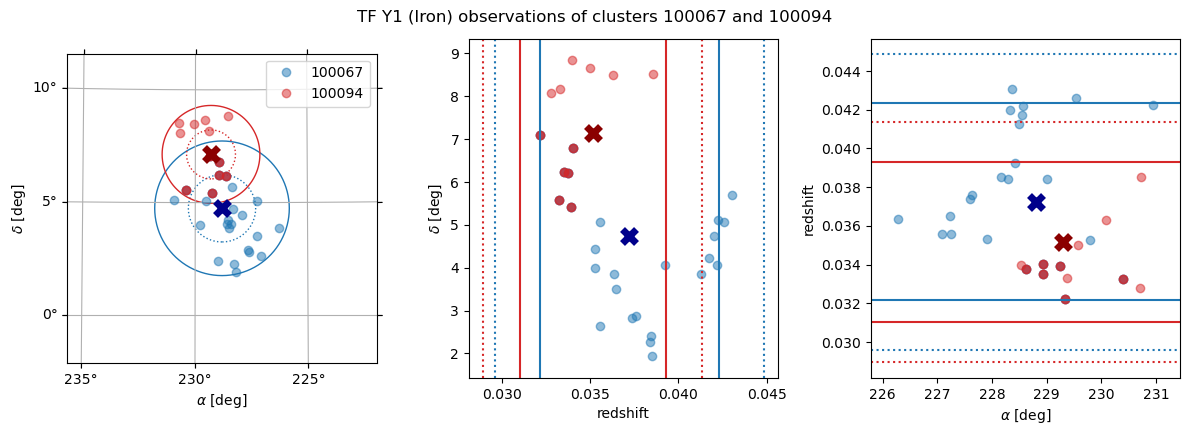

In [54]:
for i in range(len(overlap_pairs)):

    id1 = overlap_pairs[i][0]
    id2 = overlap_pairs[i][1]

    gal1 = caltab['SGA_ID'][caltab['CLUSTER_ID'] == id1]
    gal2 = caltab['SGA_ID'][caltab['CLUSTER_ID'] == id2]

    fig = plot_double_clusters(clusters, id1, id2, caltab, gal1, gal2)

# Save "cleaned" calibration galaxy tables

## Remove just those clusters which sit inside another

Here, that's just 100094

In [57]:
caltab_clean1 = caltab[caltab['CLUSTER_ID'] != 100094]

caltab_clean1.write('SGA-2020_iron_Vrot_cluster-noPairs_calib_z0p1_Anthony.fits')

caltab_clean1

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,MORPHTYPE_AI,JOHN_VI,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,CLUSTER_ID
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,,,,,,,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,bytes10,bytes6,float64,float64,float64,float64,float64,float64,int64
35725.0,SGA-2020 35725,PGC1224815,1224815,218.516655,2.3732835,S?,119.7,0.414954,0.31622776,0.028805595,24.58048,17.862,False,LEDA-20181114,9560,PGC1224815,1,True,218.516655,2.3732835,0.414954,2186p022,218.51673945189452,2.3732654125607757,0.7285664,SB26,119.49577,0.29847997,218.51645511612097,2.373413119352272,13.986177,8.9652,8.8493,8.537395,2.637311,5.3980026,7.7491693,10.108394,12.475642,14.781089,16.927706,19.368849,21.856993,20.057823,19.502214,19.152143,18.8512,18.349913,18.02569,18.36864,17.89226,17.569437,18.064114,17.604765,17.291239,17.866943,17.421322,17.12161,17.74925,17.301216,17.010185,17.675014,17.230236,16.939669,17.61827,17.176155,16.888216,17.581612,17.139238,16.852167,0.036243405,0.052957676,0.08686163,0.105829716,0.11953892,0.1407899,0.12557544,0.17631544,0.25353405,0.04001302,0.044960078,0.05253993,0.026287124,0.028849348,0.031466525,0.02200045,0.023913907,0.025489496,0.019614518,0.021171868,0.022508515,0.018323934,0.019594736,0.020753864,0.01745466,0.01849219

## Remove all clusters that overlap with another

In [59]:
caltab_clean2 = caltab_clean1[caltab_clean1['CLUSTER_ID'] != 100067]

caltab_clean2.write('SGA-2020_iron_Vrot_cluster-noOverlaps_calib_z0p1_Anthony.fits')

caltab_clean2

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,MORPHTYPE_AI,JOHN_VI,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,CLUSTER_ID
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,,,,,,,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,bytes10,bytes6,float64,float64,float64,float64,float64,float64,int64
35725.0,SGA-2020 35725,PGC1224815,1224815,218.516655,2.3732835,S?,119.7,0.414954,0.31622776,0.028805595,24.58048,17.862,False,LEDA-20181114,9560,PGC1224815,1,True,218.516655,2.3732835,0.414954,2186p022,218.51673945189452,2.3732654125607757,0.7285664,SB26,119.49577,0.29847997,218.51645511612097,2.373413119352272,13.986177,8.9652,8.8493,8.537395,2.637311,5.3980026,7.7491693,10.108394,12.475642,14.781089,16.927706,19.368849,21.856993,20.057823,19.502214,19.152143,18.8512,18.349913,18.02569,18.36864,17.89226,17.569437,18.064114,17.604765,17.291239,17.866943,17.421322,17.12161,17.74925,17.301216,17.010185,17.675014,17.230236,16.939669,17.61827,17.176155,16.888216,17.581612,17.139238,16.852167,0.036243405,0.052957676,0.08686163,0.105829716,0.11953892,0.1407899,0.12557544,0.17631544,0.25353405,0.04001302,0.044960078,0.05253993,0.026287124,0.028849348,0.031466525,0.02200045,0.023913907,0.025489496,0.019614518,0.021171868,0.022508515,0.018323934,0.019594736,0.020753864,0.01745466,0.01849219